# Comparative Analysis of MAC and LSGA Approaches


> Gianmaria Pizzo - 872966@stud.unive.it

This notebook is part of the First Assignment Submission for the course [Foundations of Artificial Intelligence](https://www.unive.it/data/insegnamento/513734) taught by Professor [Andrea Torsello](https://www.unive.it/data/persone/5590629) at [Ca' Foscari University of Venice](https://www.unive.it).

---

## Structure of this notebook

This notebook covers the following points
* Dataset Overview
* Analysis of CSP Results
* Analysis of LSGA Results
* Comparative Analysis of CSP approach and LSGA approach

---

### Before running this notebook

To avoid issues, before running the following notebook it is best to
* Clean previous cell outputs
* Restart the kernel

## Environment, Imports and Global Variables

In [1]:
# Interactive
# %matplotlib notebook
# Static
%matplotlib inline

# Environment for this notebook
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import warnings
import IPython

# Set the style for the plots
sns.set()
plt.style.use('ggplot')
sns.set_style("darkgrid")
# Ignore warnings
warnings.filterwarnings('ignore')

## Workspace Setup and Data Loading

In [2]:
# Working folder, where this file is at
WORKING_DIR = os.getcwd()

# Find the right directory
DATA_DIR = os.path.join(os.path.dirname(WORKING_DIR), 'data')

# Find dataset
DF_DIR = os.path.join(DATA_DIR, 'raw', 'sudoku_cluewise.csv')
# Find CSP results
CSP_DIR = os.path.join(DATA_DIR, 'benchmark', 'csp_benchmark.csv')
# Find LSGA results
LSGA_DIR = os.path.join(DATA_DIR, 'benchmark', 'lsga_benchmark.csv')

DF_DIR, CSP_DIR, LSGA_DIR

('C:\\Users\\PayThePizzo\\Projects\\SudokuSolver\\data\\raw\\sudoku_cluewise.csv',
 'C:\\Users\\PayThePizzo\\Projects\\SudokuSolver\\data\\benchmark\\csp_benchmark.csv',
 'C:\\Users\\PayThePizzo\\Projects\\SudokuSolver\\data\\benchmark\\lsga_benchmark.csv')

In [ ]:
# Import the Dataset
df = pd.read_csv(DF_DIR)

# Import the results for CSP
csp_df = pd.read_csv(CSP_DIR)

# Import the results for LSGA
LSGA_df = pd.read_csv(LSGA_DIR)

## Utility Functions

### Sudoku Utilities

In [3]:
# Utility function for Sudoku
def string_to_sudoku_board(puzzle: str, empty_cell: str = '0', to_np_array: bool = False):
    """Convert a string into a 2D Sudoku board and return it.

    This function gathers the string and verifies its validity
    by checking:
        - The puzzle and the empty cell must be strings.
        - The empty
    if the empty
    cell symbol is coherent with the content of the string. Then
    it creates a 2D array of integers, substituting the empty cell
    symbol with a `0`.
    The returned array-like structure can be
    returned as `np.array`.

    Args:
        puzzle (str): A string of length 81, containing
            digits 1-9 and one empty cell symbol.
        empty_cell (str): A string representing the empty
            celll symbol.

    Raises:
        TypeError: When `puzzle` or `empty_cell` are not
            strings
        ValueError: When `puzzle` length is not exactly 81,
            or when the unique digits are not exactly 1-9 plus
            the empty cell symbol (hence 10).

    Returns:
        list[list[int]] or np.array: An array-like 2D 9x9 list of integers
            representing the sudoku board puzzle.
    """
    # Check type
    if not isinstance(puzzle, str) or not isinstance(empty_cell, str):
        raise TypeError(
            'The arguments puzzle and empty_cell must be strings.'
        )

    # Check length
    if len(puzzle) != 81 or len(empty_cell) != 1:
        raise ValueError(
            'The argument puzzle must be exactly 81 digits long,\n' +
            'while empty_cell must be a string of ' +
            'exactly 1 digit.'
        )

    # Find the unique values in the string
    unique_values = set(puzzle)
    # Record the valid values for sudoku
    valid_values = set('123456789')
    valid_values.add(empty_cell)

    # Check if unique set is subset of valid set and length is respected
    if len(unique_values) > 10 or not (unique_values <= valid_values):
        raise ValueError(
            'The puzzle string must contain exactly 10 unique values:' +
            'digits 1-9 and one empty cell symbol. '
        )

    # Construct Board
    board = []

    for idx_r in range(9):
        row = []
        for idx_c in range(9):
            # Check value
            cell = puzzle[idx_r * 9 + idx_c]

            # Append correct value to row
            if cell == empty_cell:
                row.append(0)
            else:
                row.append(int(cell))

        board.append(row)

    # Convert to np.array
    if to_np_array:
        board = np.array(board)

    return board


def print_sudoku_board(puzzle) -> None:
    """Print the Sudoku board in a formatted way.

    Args:
        puzzle (np.ndarray): A 9x9 matrix representing the Sudoku board.

    Returns:
        None
    """
    for i in range(9):
        # Print horizontal lines for sub-grids
        if i % 3 == 0 and i != 0:
            print('-' * 21)
        # Print each row
        row = (
            ' | '.join(
                ' '.join(
                    str(num)
                    if num != 0 else '.'
                    for num in puzzle[i, j: j+3]
                ) for j in range(0, 9, 3)
            )
        )
        print(row)

    pass


def is_valid_solution(board) -> bool:
    """Check if a given 9x9 numpy array represents a valid Sudoku solution.

    Args:
        board (np.array): A 9x9 grid of integers.

    Returns:
        bool: True if the board is a valid Sudoku solution, False otherwise.
    """
    # Check if the shape is 9x9
    if board.shape != (9, 9):
        return False

    # Check each row, column, and 3x3 subgrid for validity
    for i in range(9):
        # Check if each row and column contain numbers 1 to 9 without repetition
        if not (np.array_equal(np.sort(board[i, :]), np.arange(1, 10)) and
                np.array_equal(np.sort(board[:, i]), np.arange(1, 10))):
            return False

        # Check the 3x3 subgrid
        row_offset = (i // 3) * 3
        col_offset = (i % 3) * 3
        subgrid = board[row_offset:row_offset+3, col_offset:col_offset+3].flatten()
        if not np.array_equal(np.sort(subgrid), np.arange(1, 10)):
            return False

    return True


### Pandas Utilities

In [4]:
# Utility functions for rows and columns

def sort_alphabetically(dataset, last_label = None):
    """
    Sorts the dataset alphabetically and leaves last_label for last

    :param dataset: a pd.DataFrame
    :param last_label: a str containing an existing column label in the dataset
    :returns: pd.DataFrame
    """
    # Sort
    dataset = dataset.reindex(sorted(dataset.columns), axis=1)
    # Move target column to last index
    if last_label is not None:
        col = dataset.pop(last_label)
        dataset.insert(dataset.shape[1], last_label, col)
    return dataset

def get_cols(dataset, col_substring):
    """
    Returns the dataset having only the columns matching the substring, that are in the dataset
    
    :param dataset: pandas.DataFrame
    :param col_substring: a list of str
    :returns: a list of columns present inside dataset, matching the substring
    """
    if col_substring is not None:
        all_columns = list(dataset.columns)
        # Add only if in dataset
        col_lst = [i for i in all_columns if col_substring in i]
        return col_lst
    return None

def drop_if_exists(dataset, to_drop: list, inplace=True):
    """
    Drops rows from list to_drop if they are found inside the dataset
    
    :param dataset: a pd.DataFrame
    :param to_drop: a list of str containing existing column labels in the dataset to drop
    :param inplace: a boolean representing whether to drop column in place, if True it returns None
    :returns: None if inplace is True, else a pd.DataFrame without the columns in to_drop (if present in dataset)
    """
    all_columns = list(dataset.columns)
    # Include only columns that are existing 
    cols_to_drop = [i for i in all_columns if i in to_drop]
    if cols_to_drop is not None:
        if inplace:
            return dataset.drop(columns = cols_to_drop, inplace=inplace)
        return dataset.drop(columns = cols_to_drop, inplace=inplace)
    pass

def drop_rows_cond(dataset, condition, inplace = True):
    """
    Drops rows on boolean condition and resets index
    
    :param dataset: pandas.DataFrame
    :param condition: boolean condition between braces, regarding this dataset (such as: (dataset['Label']!=0) )
    :param inplace: boolean
    :returns: pandas.DataFrame if inplace = False, else None
    """
    rows_to_drop = dataset[condition].index.tolist()
    if inplace:
        dataset.drop(rows_to_drop, inplace=inplace)
        dataset.reset_index(drop=True, inplace=inplace)
    else:
        return dataset.drop(rows_to_drop)

### Plot Utilities

In [5]:
# Plot functions for numeric features

def plot_frequency_distr_numeric(dataset, exclude = None, include_kde=False, plot_cols=2, notebook_fig_size=None, adjust=None):
    """
    Plots the frequency distributions of its numeric features through histograms from seaborn
    
    :param exclude: a string list representing the columns to exclude
    :param include_kde: boolean representing whether to include kde
    :param dataset: pandas dataframe
    :param plot_cols: count of plots per column
    :param notebook_fig_size: dictionary of integers including keys 'width', 'height' which represent the measures in inches for notebook display purposes
    :param adjust: dictionary of float including keys 'left', 'right', 'top', 'bottom', 'wspace', 'hspace' which are used to space the different plots between them
    """
    # Numeric dataframe
    num_df = dataset.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
    
    if exclude is not None:
        num_df = num_df.drop(exclude, axis=1)
    
    # Set subplot shape
    fig, axes = plt.subplots(nrows = int(np.ceil(num_df.shape[1]/plot_cols)), ncols = plot_cols, figsize=(9,2))
    # Flat 1-D flat iterator over the array.
    axes = axes.flatten()
    
    # Notebook figure dimensions
    if notebook_fig_size is None:
        # Default
        fig.set_size_inches(10, 40)
    else:
        fig.set_size_inches(notebook_fig_size.get('width'), notebook_fig_size.get('height'))
    
    # Plot distribution for each feature
    for ax, col in zip(axes, num_df.columns):
        sns.histplot(data=num_df, y=col, ax = ax, color='cornflowerblue', kde=include_kde, stat='count')
        ax.set_title(col.replace("_", " ")+'\'s Distribution', fontweight='bold')
        ax.set_ylabel('Values')
        ax.set_xlabel('Count')
        
    # Adjust spacing between plots
    if adjust is None:
        # Default
        plt.subplots_adjust(left=0.1, right=0.9, top=0.98, bottom=0.05, wspace=0.4, hspace=0.9)
    else:
        plt.subplots_adjust(left=adjust.get('left'), right=adjust.get('right'), 
                            top=adjust.get('top'), bottom=adjust.get('bottom'),
                            wspace=adjust.get('wspace'), hspace=adjust.get('hspace'))
    pass

# Util function for pretty printing
def print_num_col_skewness(dataset, exclude = None):
    """
    Prints the skewness of the numeric columns in the dataset
    
    : param dataset: pandas.DataFrame
    : param exclude: list of str representing column labels to exclude
    : returns: None
    """
    for x in dataset.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']):
        if exclude is not None and x in exclude:
            continue
        else:
            print("Skewness of " + x + ": \n" + str(scipy.stats.skew(df[""+x])) + "\n")
    pass

In [6]:
# Utility function for categorical features

from itertools import zip_longest

# We use a decoded version of the dataset to display the labels better
def decode_byte_str(dataset):
    """
    Decodes the dataset's object feature values in place and substitutes the byte-code string formatting b''
    
    : param dataset: a pandas.DataFrame
    : returns: None
    """
    categorical = dataset.select_dtypes(object)
    categorical = categorical.stack().str.decode('utf-8').unstack()
    for col in categorical:
        dataset[col] = categorical[[col]].apply(lambda x: x.str.replace("b'", "").str.replace("'", ""))
    pass

def barplot_categ(dataset):
    """
    Produces a barplot for a dataset, including only the object types
    
    : param dataset: a pandas.DatFrame
    : returns: None
    """
    # Categorical Features Only 
    categorical_data = dataset.select_dtypes(object)
    # Rows
    n = categorical_data.shape[1]
    # Params for subplots
    nrows, ncols = (int(np.ceil(n / 2))+1, 2)

    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(9.9, 60))
    
    for feature_name, ax in zip_longest(categorical_data, axs.ravel()):
        if feature_name is None:
            # Avoid showing axis
            ax.axis("off")
            continue

        ax = categorical_data[feature_name].value_counts().plot.barh(ax=ax, color='cornflowerblue')
        ax.set_title(feature_name + '\'s Frequency', fontweight='bold')
        ax.set_xlabel('Count', fontsize = 8)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.tick_params(axis='both', which='minor', labelsize=6)
        plt.setp(ax.get_yticklabels(), rotation=40)

    plt.subplots_adjust(left=0.2,
                    bottom=0.02,
                    right=0.9,
                    top=0.98,
                    wspace=0.9,
                    hspace=0.9)
    pass


def boxplot_categ(dataset, target):
    """
    Produces a target related boxplot for a dataset, including only the object types
    
    : param dataset: a pandas.DatFrame
    : param target: a string label for a column
    : returns: None
    """
    # Categorical Features Only 
    categorical_data = dataset.select_dtypes(object)
    # Rows
    n = categorical_data.shape[1]
    # Params for subplots
    nrows, ncols = (n, 1)
    
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, n*7))
    
    for feature_name, ax in zip_longest(categorical_data, axs.ravel()):
        if feature_name is None:
            # Avoid showing axis
            ax.axis("off")
            continue   
        ax = dataset[[target, feature_name]].boxplot(ax=ax, rot = 45,
                                                     column=target,
                                                     by=feature_name)
        ax.set_title(feature_name + ' Boxplot', fontweight='bold')
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.tick_params(axis='both', which='minor', labelsize=6)
        plt.setp(ax.get_yticklabels(), rotation=40)

    plt.subplots_adjust(left=0.2,
                    bottom=0.03,
                    right=0.9,
                    top=0.96,
                    wspace=0.7,
                    hspace=0.7)
    pass

In [7]:
# Utility distribution and probability functions to plot numerical features

from scipy import stats
from scipy.stats import probplot

# Module for numerical variables
def get_df_wo_outliers(dataset: pd.core.frame.DataFrame , label: str, threshold=(0.05,99.95)):
    """
    Returns a copy of the given dataset, after removal of the extreme values specified for a numeric label
    
    : param dataset: pd.core.frame.DataFrame
    : param label: str representing an existing column
    : param threshold: tuple of 2 float representing the extremes to drop
    : returns: pd.core.frame.DataFrame
    """
    if dataset.empty or not isinstance(dataset, pd.core.frame.DataFrame):
        raise Exception("Dataset is either empty or not a valid pandas DataFrame")
    if not isinstance(label, str):
        raise Exception("label is not a string")
    if label not in dataset.columns:
        raise Exception("label not in dataset")
    if dataset[label].dtype == object:
        raise Exception("Categorical features are not allowed")
    if (type(threshold) != tuple or len(threshold) != 2) or (type(threshold[0]) != float or type(threshold[1]) != float):
        raise Exception("Threshold must be an float tuple of length 2")
    if threshold[0] > threshold[1]:
        raise Exception("The element in position 0 should smaller than the one in position 1")
    if threshold[0] < 0.0 or threshold[1] > 100.0:
        raise Exception("Threshold out of range")
    
    stats_dict = dataset[label].describe().to_dict()
    uppr = np.percentile(dataset[label].values, float(threshold[1]))
    lwr = np.percentile(dataset[label].values, float(threshold[0]))
    return dataset.loc[(dataset[label] >= lwr) & (dataset[label] < uppr)]


def numeric_distr_plot(dataset: pd.core.frame.DataFrame , label: str, shape=(9.8, 6.0)):
    """
    Plots distribution of the given dataset's column specified in label
    :param dataset: pd.core.frame.DataFrame
    :param label: str representing an existing column
    :param shape: tuple of 2 float representing the shape of the figure
    :returns: None
    """
    if dataset.empty or not isinstance(dataset, pd.core.frame.DataFrame):
        raise Exception("Dataset is either empty or not a valid pandas DataFrame")
    if not isinstance(label, str):
        raise Exception("label is not a string")
    if label not in dataset.columns:
        raise Exception("label not in dataset")
    if dataset[label].dtype == object:
        raise Exception("Categorical features are not allowed")
    if (type(shape) != tuple or len(shape) != 2) or (type(shape[0]) !=float or type(shape[1]) !=float):
        raise Exception("Threshold must be an float tuple of length 2")
                               
    # Normal Distribution fit
    (mu, sigma) = stats.norm.fit(dataset[label])

    # Feature Distribution Plot
    plt.figure(figsize=shape)
    sns.distplot(dataset[label], hist=True, kde=True, fit=stats.norm, color='cornflowerblue')
    
    # Figure labels
    plt.title(label.replace("_", " ") + '\'s Distribution vs Normal Distribution', fontsize=14)
    plt.xlabel(label.replace("_", " "))
    plt.ylabel('Frequency in %')
    plt.legend(['Normal Dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='upper right')
    plt.show()
    pass

def probability_plot(dataset: pd.core.frame.DataFrame , label: str):
    """
    Plots QQplot of target feature vs normal distribution
    :param dataset: pd.core.frame.DataFrame
    :param label: str representing an existing column
    :returns: None
    """
    if dataset.empty or not isinstance(dataset, pd.core.frame.DataFrame):
        raise Exception("Dataset is either empty or not a valid pandas DataFrame")
    if not isinstance(label, str):
        raise Exception("label is not a string")
    if label not in dataset.columns:
        raise Exception("label not in dataset")
    if dataset[label].dtype == object:
        raise Exception("Categorical features are not allowed")
    
    fig = plt.figure()
    res = stats.probplot(dataset[label], plot=plt)
    plt.show()
    pass

def scatterplot_distr(dataset: pd.core.frame.DataFrame , label: str, shape=(9.8, 6.0)):
    """
    Plots QQplot of target feature vs normal distribution
    :param dataset: pd.core.frame.DataFrame
    :param label: str representing an existing column
    :param shape: tuple of 2 float representing the shape of the figure
    :returns: None
    """
    if dataset.empty or not isinstance(dataset, pd.core.frame.DataFrame):
        raise Exception("Dataset is either empty or not a valid pandas DataFrame")
    if not isinstance(label, str):
        raise Exception("label is not a string")
    if label not in dataset.columns:
        raise Exception("label not in dataset")
    if dataset[label].dtype == object:
        raise Exception("Categorical features are not allowed")
    if (type(shape) != tuple or len(shape) != 2) or (type(shape[0]) !=float or type(shape[1]) !=float):
        raise Exception("Threshold must be an float tuple of length 2")
        
    plt.figure(figsize=shape)
    plt.scatter(range(dataset[label].shape[0]), np.sort(dataset[label].values))
    plt.title(label + '\'s Scatter Plot')
    plt.xlabel('Index', fontsize=12)
    plt.ylabel(label, fontsize=12)
    plt.show()
    pass

### Correlation Utilities

In [16]:
# Utility functions for correlation analysis

def display_corr_matrix(dataset: pd.core.frame.DataFrame, label: str, exclude = None):
    """
    Displays the correlation matrix and returns it
    : param dataset: pd.core.frame.DataFrame
    : param label: str representing an existing column
    : param exclude: list of str of features to exclude
    : returns: correlation matrix
    """
    if dataset.empty or not isinstance(dataset, pd.core.frame.DataFrame):
        raise Exception("Dataset is either empty or not a valid pandas DataFrame")
    if not isinstance(label, str):
        raise Exception("label is not a string")
    if label not in dataset.columns:
        raise Exception("label not in dataset")
    if dataset[label].dtype == object:
        raise Exception("Categorical features are not allowed")
    
    if exclude is not None:
        if type(exclude) == list:
            for i in exclude:
                if type(i)!= str:
                    raise Exception("exclude must be a list of string")
                if i not in dataset.columns:
                    raise Exception(i + " is not a valid column label")
        else:
            raise Exception("exclude must be a list")
            
    # Move target column to last index
    col = dataset.pop(label)
    dataset.insert(dataset.shape[1], label, col)

    plt.figure(figsize=(20,20))
    
    matrix = dataset.corr()

    cmap = sns.diverging_palette(250, 15, s=75, l=40,
                                 n=9, center="light", as_cmap=True)
    mask = np.triu(np.ones_like(matrix, dtype=bool))

    sns.heatmap(matrix, mask=mask, center=0, annot=True,
                 fmt='.2f', square=True, cmap=cmap)
    return matrix


def top_correlated_features(corr_matrix, label, threshold=0.45):
    """
    Returns a dictionary of the top correlated features with label, inside the dataset, for a certain threshold
    
    """
    
    m = corr_matrix[label].sort_values(ascending=False).to_dict()
    corr_dict = {}
    
    for k in m:
        if label in k:
            continue
        else:
            v = m.get(k)
            if v >= threshold or v <= (-threshold):
                corr_dict.update({k:v})
    return corr_dict


def display_correlation(sample_dict, exclude=None):
    """
    Prints the correlated features for all the top correlated features with the target
    
    """
    for k in sample_dict:
        print("Top correlated features with \"{0}\"".format(k))
        temp = top_correlated_features(corr, k, .60)
        for k in temp:
            if exclude is not None and k in exclude:
                continue
            print("\t{0} : {1}".format(k, temp.get(k)))
        print("\n")
    pass

### Numeric Plot Utilities

In [9]:
# Module for categorical variables
def scatterplot_single(dataset, target, label, hue=None):
    """
    Quick ad hoc function to display a scatterplot
    
    """
    sns.lmplot(data=dataset, x=target, y=label, aspect=1.5, scatter=True, hue=hue)
    pass

def scatterplot_multiple(dataset, target, labels, plot_cols=1, notebook_fig_size=None, adjust=None, hue=None):
    """
    Quick ad hoc function to display multiple scatterplots
    
    """
    
    fig, axes = plt.subplots(nrows = int(np.ceil(len(labels)/plot_cols)), ncols = plot_cols)

    # Flat 1-D flat iterator over the array.
    axes = axes.flatten()

    # Notebook figure dimensions
    if notebook_fig_size is None:
        # Default
        fig.set_size_inches(9, 8*plot_cols)
    else:
        fig.set_size_inches(notebook_fig_size.get('width'), notebook_fig_size.get('height'))

    # Plot 
    for ax, col in zip(axes, dataset.loc[:, dataset.columns.isin(labels)].columns):
        sns.regplot(data=dataset, x=target, y=col, fit_reg=True, scatter=True, ax=ax)
        ax.set_title(col + " vs " + target, fontweight='bold')
        ax.set_xlabel(col)
        ax.set_ylabel(target)

    # Adjust 
    if adjust is None:
        # Default
        plt.subplots_adjust(left=0.2, right=0.9, top=0.95, bottom=0.1, wspace=0.4, hspace=0.5)
    else:
        plt.subplots_adjust(left=adjust.get('left'), right=adjust.get('right'), 
                            top=adjust.get('top'), bottom=adjust.get('bottom'),
                            wspace=adjust.get('wspace'), hspace=adjust.get('hspace'))
    pass


def stripplot_single(dataset, target, categ_feat, figsize=None):
    """
     Quick ad hoc function to display stripplot
    
    """
    
    if figsize is None:
        fig, ax = plt.subplots(figsize=(11,7))
    else:
        fig,ax = plt.subplots(figsize=figsize)
    
    sns.stripplot(y=categ_feat, x=target, data =dataset, jitter = True, dodge = True, ax=ax)
    pass

## Dataset overview: 4 Million Sudoku Puzzles

This Dataset was created by [RyanAn](https://www.kaggle.com/informoney) and can be found on [Kaggle](https://www.kaggle.com/datasets/informoney/4-million-sudoku-puzzles-easytohard/code).

The dataset is designed to test the effectiveness of Sudoku-solving algorithms across a spectrum of puzzle difficulties, with puzzles ranging from easy to very challenging levels. Each puzzle's difficulty correlates with the number of clues (pre-filled digits), where more clues indicate an easier puzzle and fewer clues imply a more challenging one.

In this project, we test our algorithms on random samples 5 random samples of 50 sudokus. Each random sample has an increasing difficulty, in particular two of them have a strict range of clues to test the algorithms on very hard problems (less than 25 clues).


### Key Characteristics
- **Difficulty and Clues**: 
    - Each puzzle has between 17 and 80 clues.
    - **Easy puzzles** have up to 80 clues, making them quicker to solve.
    - **Hard puzzles** contain as few as 17 clues, which is the minimum necessary to form a solvable puzzle.
- **Magic Number 17**: 
    - A 17-clue puzzle is the threshold for having a valid and solvable Sudoku puzzle with guaranteed logic-based solutions.

### Dataset Structure
- **Total Puzzles**: 4 million unique puzzles.
- **Puzzle Distribution**: 62,500 puzzles for each clue count from 17 to 80, allowing comprehensive coverage across difficulty levels.
- **Format**: Each entry contains a puzzle and its solution.

### Unique and Non-Unique Solutions
- **Non-Unique Solutions**: Due to Sudoku’s mathematical principles, some puzzles might have multiple valid solutions.
- **Answer Checker**: Users are advised to compare solutions with the provided answers in the dataset before implementing answer checkers, especially for large-scale tests (10,000+ puzzles).


In [11]:
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 3 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   quizzes       object
 1   solutions     object
 2   clue_numbers  int64 
dtypes: int64(1), object(2)
memory usage: 91.6+ MB


### Data Sample

In [42]:
set(csp_df['index'])

{58841,
 70313,
 73348,
 86823,
 122086,
 141831,
 162899,
 176818,
 214028,
 310912,
 315243,
 326819,
 353000,
 373052,
 387629,
 403622,
 457441,
 505500,
 529532,
 553197,
 589548,
 622331,
 634644,
 674138,
 685884,
 691597,
 694944,
 698154,
 711637,
 747391,
 777957,
 779023,
 804448,
 811773,
 895340,
 954179,
 957396,
 977138,
 991744,
 1062074,
 1073223,
 1077115,
 1096555,
 1133194,
 1174791,
 1188666,
 1201798,
 1221747,
 1225382,
 1246576,
 1308841,
 1320313,
 1323348,
 1336823,
 1372086,
 1391831,
 1412899,
 1426818,
 1464028,
 1560912,
 1565243,
 1576819,
 1603000,
 1623052,
 1637629,
 1653622,
 1707441,
 1755500,
 1779532,
 1803197,
 1839548,
 1872331,
 1884644,
 1924138,
 1935884,
 1941597,
 1944944,
 1948154,
 1961637,
 1997391,
 2027957,
 2029023,
 2054448,
 2061773,
 2145340,
 2204179,
 2207396,
 2227138,
 2241744,
 2312074,
 2323223,
 2327115,
 2346555,
 2383194,
 2424791,
 2438666,
 2451798,
 2471747,
 2475382,
 2496576,
 2536276,
 2541223,
 2543264,
 2573016,
 25

---

## Analysis of CSP Results

In [ ]:
# Import the results for CSP
csp_df = pd.read_csv(CSP_DIR)

In [12]:
csp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     250 non-null    int64  
 1   clues                     250 non-null    int64  
 2   initialization_time_sec   250 non-null    float64
 3   execution_time_sec        250 non-null    float64
 4   min_cpu_usage_percentage  250 non-null    float64
 5   avg_cpu_usage_percentage  250 non-null    int64  
 6   max_cpu_usage_percentage  250 non-null    float64
 7   base_rss_usage_bytes      250 non-null    int64  
 8   min_rss_inc_bytes         250 non-null    int64  
 9   avg_rss_inc_bytes         250 non-null    int64  
 10  max_rss_inc_bytes         250 non-null    int64  
 11  base_vms_usage_bytes      250 non-null    int64  
 12  min_vms_inc_bytes         250 non-null    int64  
 13  avg_vms_inc_bytes         250 non-null    int64  
 14  max_vms_in

In [13]:
csp_df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).describe()

,index,clues,initialization_time_sec,execution_time_sec,min_cpu_usage_percentage,avg_cpu_usage_percentage,max_cpu_usage_percentage,base_rss_usage_bytes,min_rss_inc_bytes,avg_rss_inc_bytes,...,base_vms_usage_bytes,min_vms_inc_bytes,avg_vms_inc_bytes,max_vms_inc_bytes,recursive_calls,backtracking_steps,forward_steps,ac3_revisions,ac3_contradictions,mrv_invocations
count,2.500000e+02,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,2.500000e+02,250.000000,250.000000,...,2.500000e+02,2.500000e+02,2.500000e+02,2.500000e+02,250.00000,250.000000,250.000000,250.000000,250.000000,250.00000
mean,2.607656e+06,38.788000,0.000819,0.035631,65.943200,65.488000,65.943200,1.227695e+09,24821.760000,24821.760000,...,1.712158e+09,5.387059e+04,5.387059e+04,5.387059e+04,35.32000,10.100000,31.860000,107.912000,3.820000,35.32000
std,1.214740e+06,19.430007,0.000509,0.018321,33.528304,33.317655,33.528304,5.720714e+05,25931.504881,25931.504881,...,3.751293e+05,6.669483e+04,6.669483e+04,6.669483e+04,18.87673,20.027942,19.948538,93.103476,7.808681,18.87673
min,5.884100e+04,17.000000,0.000500,0.001300,0.000000,0.000000,0.000000,1.226240e+09,20480.000000,20480.000000,...,1.710854e+09,4.915200e+04,4.915200e+04,4.915200e+04,2.00000,0.000000,1.000000,0.000000,0.000000,2.00000
25%,1.608013e+06,22.000000,0.000700,0.020800,33.200000,33.000000,33.200000,1.227272e+09,20480.000000,20480.000000,...,1.711907e+09,4.915200e+04,4.915200e+04,4.915200e+04,20.00000,0.000000,15.000000,12.250000,0.000000,20.00000
50%,3.060335e+06,31.500000,0.000700,0.037550,66.500000,66.000000,66.500000,1.227682e+09,20480.000000,20480.000000,...,1.712116e+09,4.915200e+04,4.915200e+04,4.915200e+04,34.00000,0.000000,29.500000,88.500000,0.000000,34.00000
75%,3.676263e+06,55.000000,0.000800,0.051625,99.700000,99.000000,99.700000,1.227969e+09,20480.000000,20480.000000,...,1.712251e+09,4.915200e+04,4.915200e+04,4.915200e+04,53.00000,0.750000,51.750000,196.000000,0.750000,53.00000
max,3.997465e+06,80.000000,0.004500,0.095400,101.900000,101.000000,101.900000,1.228616e+09,356352.000000,356352.000000,...,1.712796e+09,1.101824e+06,1.101824e+06,1.101824e+06,78.00000,109.000000,68.000000,299.000000,32.000000,78.00000


---

## Analysis of LSGA Results

In [ ]:
# Import the results for LSGA
lsga_df = pd.read_csv(LSGA_DIR)

---

## Comparative Analysis of CSP approach and LSGA approach

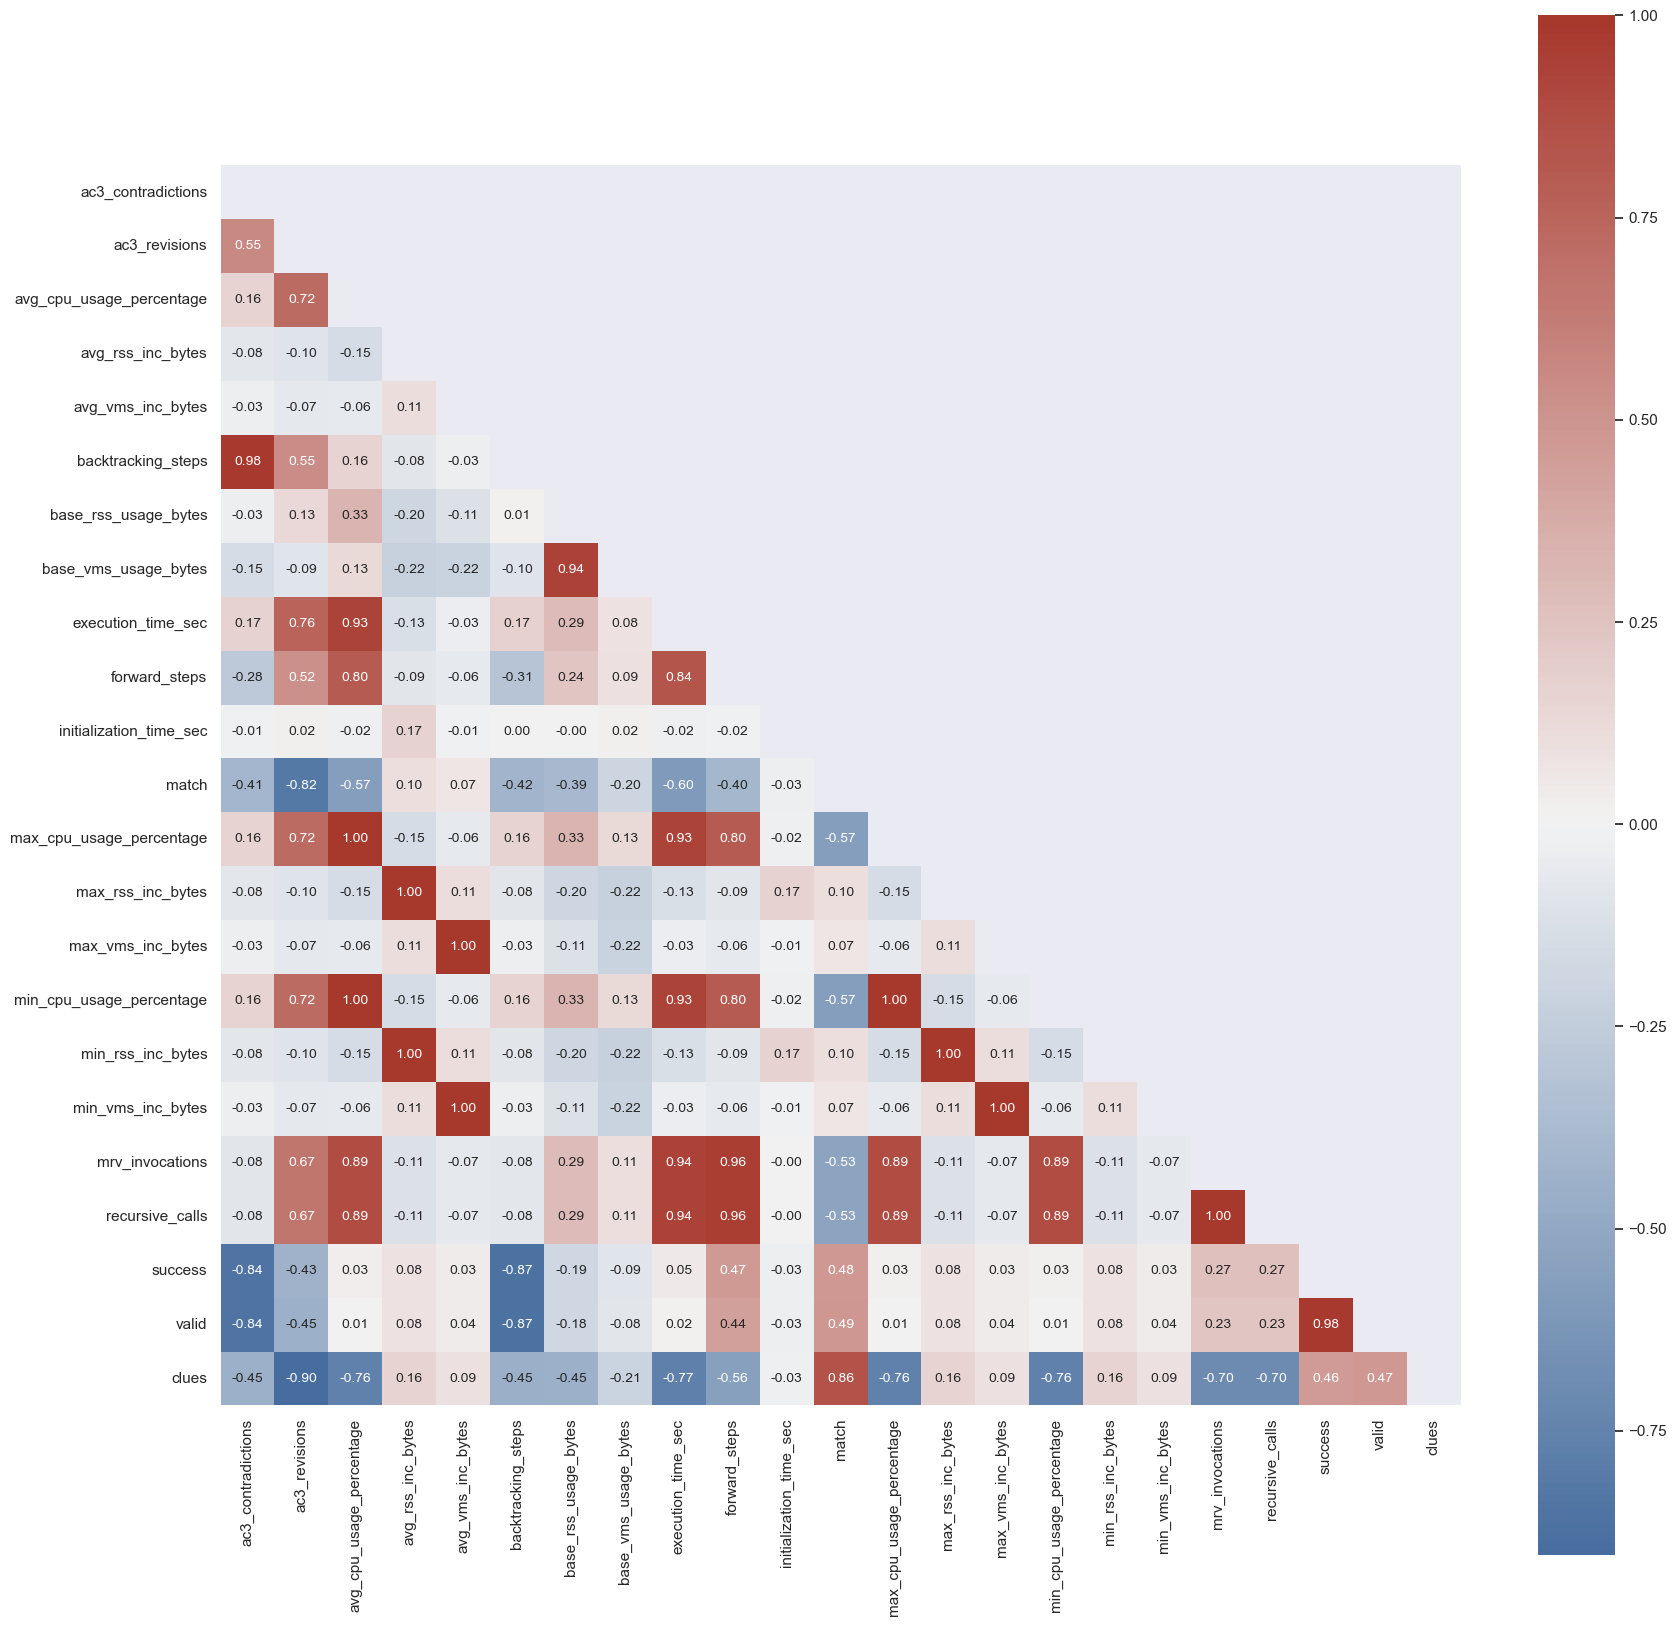

In [17]:
corr_CSP = display_corr_matrix(sort_alphabetically(csp_df.drop(columns=['index']), 'clues'), label='clues')

In [18]:
top_corr_dict_CSP = top_correlated_features(corr_CSP, 'clues', 0.40)
top_corr_dict_CSP

{'match': 0.8565764840803612,
 'valid': 0.47305363663808647,
 'success': 0.46062866816309744,
 'base_rss_usage_bytes': -0.44711679002489435,
 'ac3_contradictions': -0.4486237952840515,
 'backtracking_steps': -0.45206633686227526,
 'forward_steps': -0.5587508767589344,
 'mrv_invocations': -0.6989505898760451,
 'recursive_calls': -0.6989505898760451,
 'max_cpu_usage_percentage': -0.7630252479535083,
 'min_cpu_usage_percentage': -0.7630252479535083,
 'avg_cpu_usage_percentage': -0.7631657869465757,
 'execution_time_sec': -0.7711826661635063,
 'ac3_revisions': -0.9039861011038952}

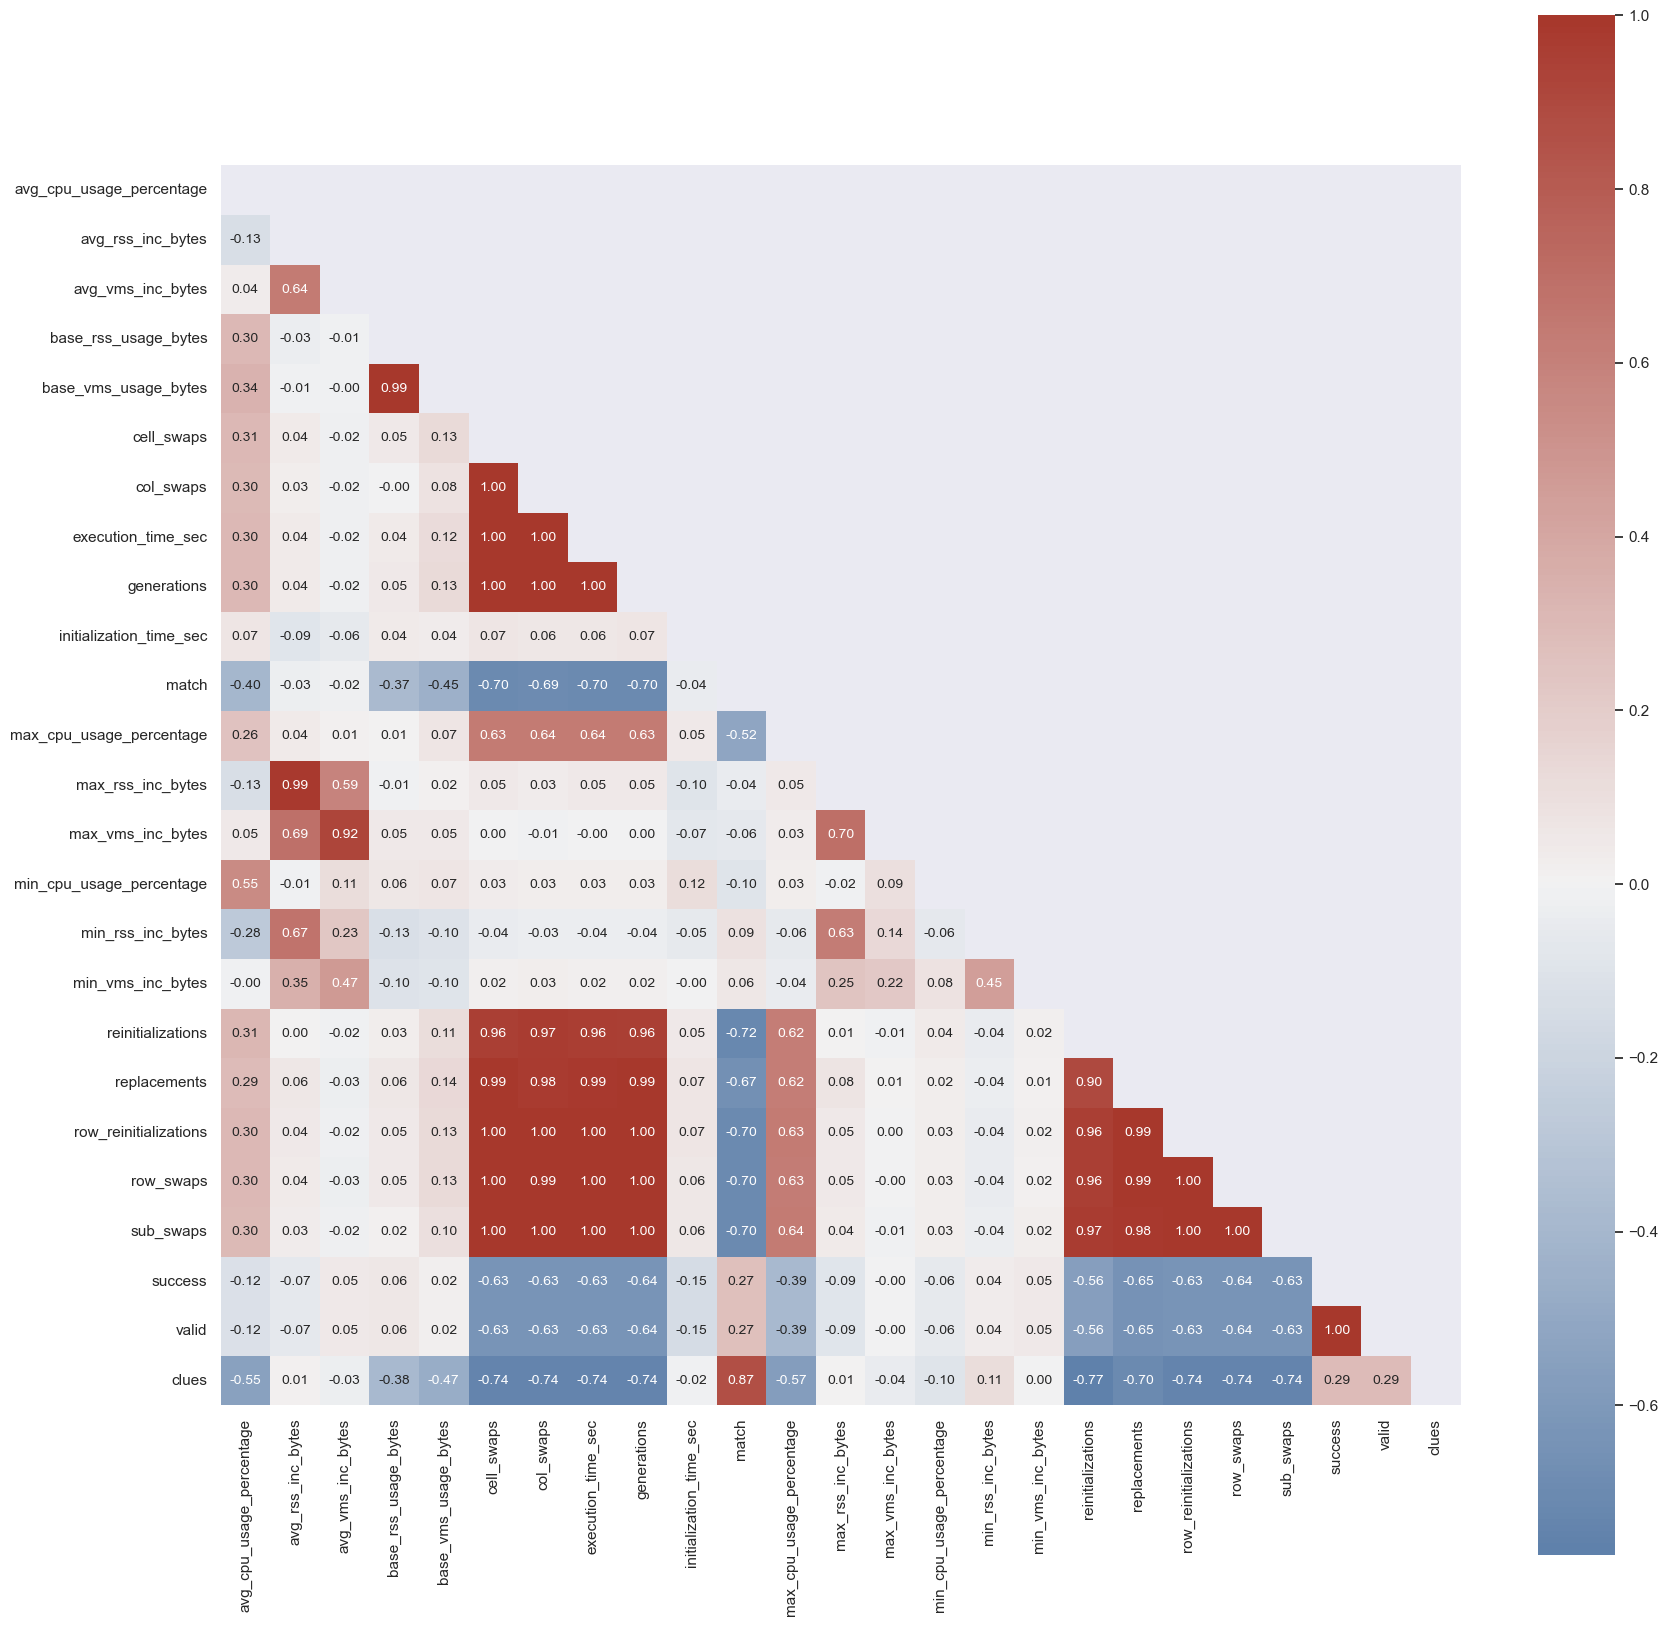

In [19]:
corr_LSGA = display_corr_matrix(sort_alphabetically(lsga_df.drop(columns=['index']), 'clues'), label='clues')

In [20]:
top_corr_dict_LSGA = top_correlated_features(corr_LSGA, 'clues', 0.40)
top_corr_dict_LSGA

{'match': 0.8654886540693458,
 'base_vms_usage_bytes': -0.4721741970606487,
 'avg_cpu_usage_percentage': -0.549090233624112,
 'max_cpu_usage_percentage': -0.5748217060423837,
 'replacements': -0.7002877095439743,
 'row_swaps': -0.7382148797355259,
 'col_swaps': -0.7386247204626287,
 'sub_swaps': -0.7403379026829826,
 'generations': -0.7409223236976532,
 'row_reinitializations': -0.74155856076049,
 'execution_time_sec': -0.742724295075593,
 'cell_swaps': -0.74351203513859,
 'reinitializations': -0.7726831629818598}

In [21]:
top_corr_dict = set(top_corr_dict_CSP.keys()) & set(top_corr_dict_LSGA.keys()) 
top_corr_dict

{'avg_cpu_usage_percentage',
 'execution_time_sec',
 'match',
 'max_cpu_usage_percentage'}

### Execution Time

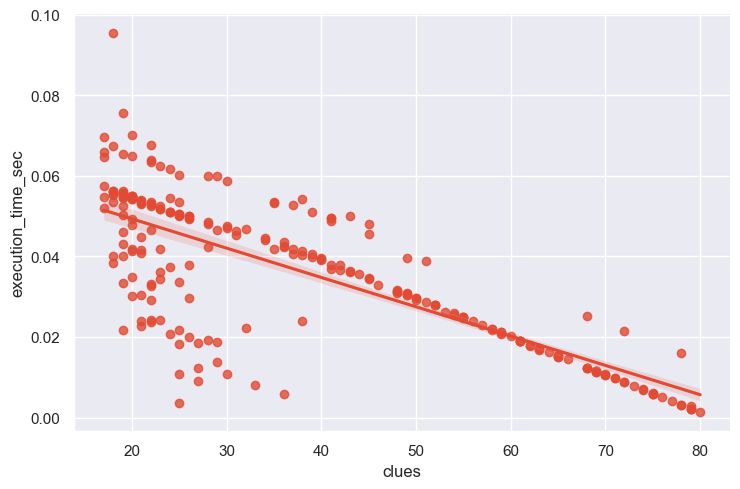

In [22]:
scatterplot_single(csp_df, 'clues', 'execution_time_sec')

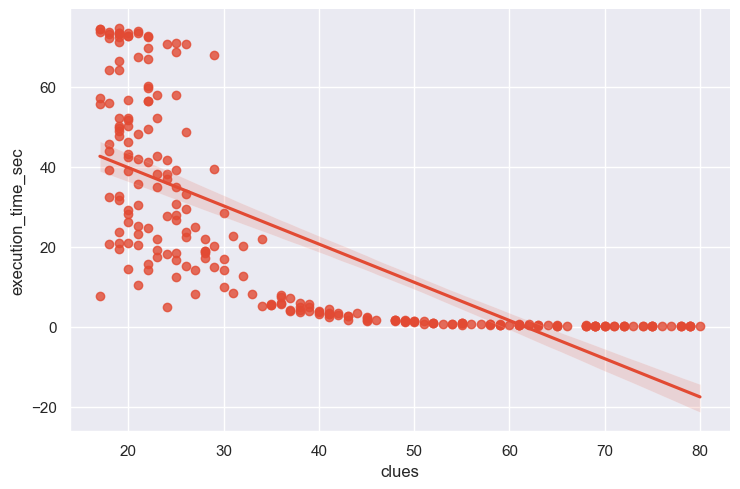

In [23]:
scatterplot_single(lsga_df, 'clues', 'execution_time_sec')

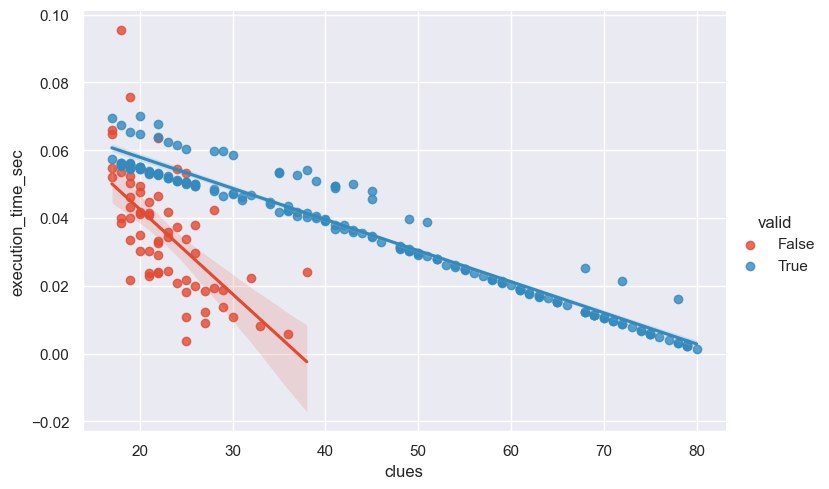

In [24]:
scatterplot_single(csp_df, 'clues', 'execution_time_sec', hue='valid')

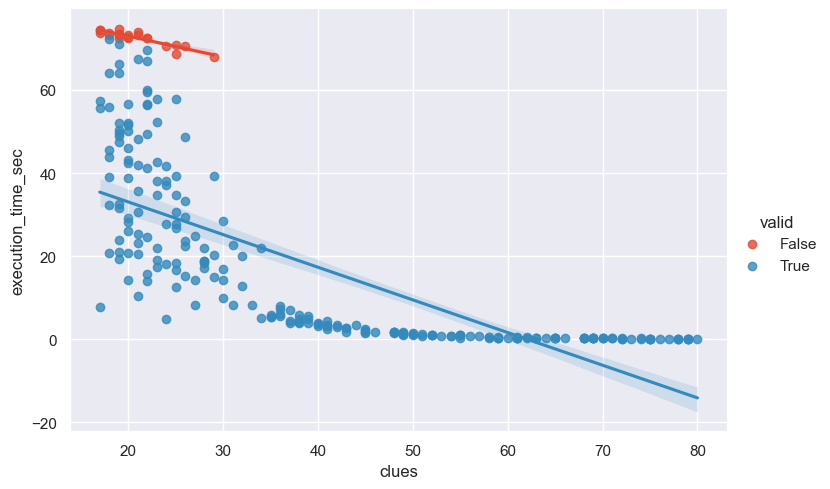

In [25]:
scatterplot_single(lsga_df, 'clues', 'execution_time_sec', hue='valid')

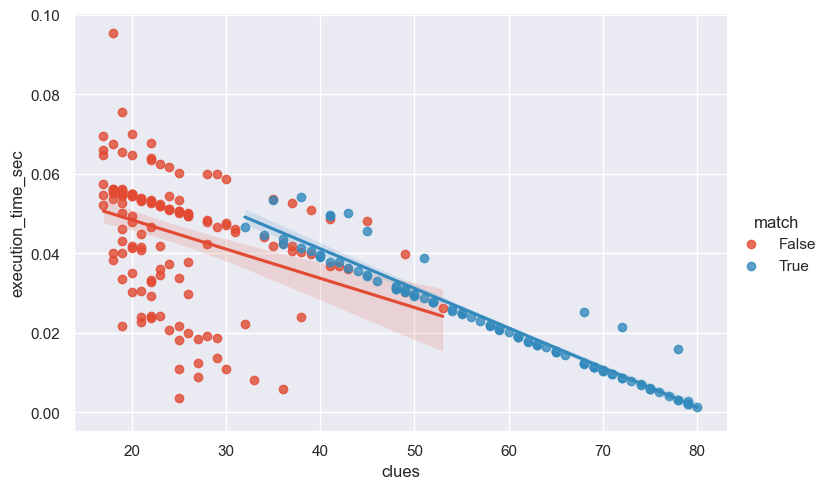

In [26]:
scatterplot_single(csp_df, 'clues', 'execution_time_sec', hue='match')

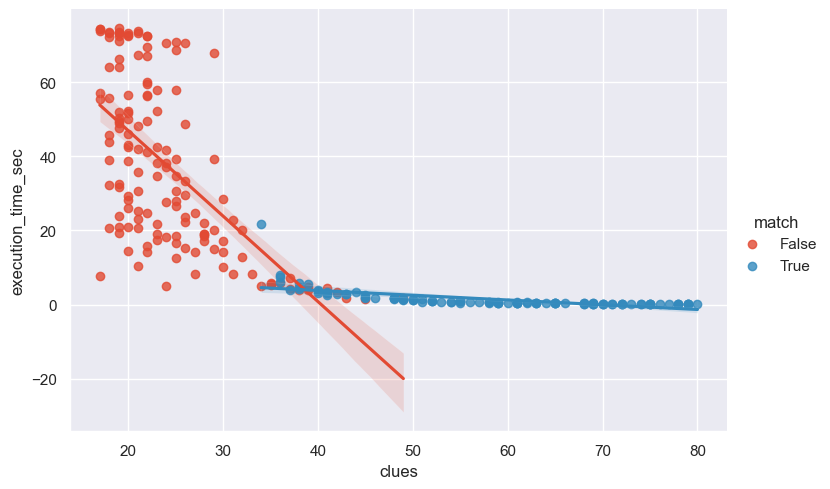

In [27]:
scatterplot_single(lsga_df, 'clues', 'execution_time_sec', hue='match')

### Average CPU Usage

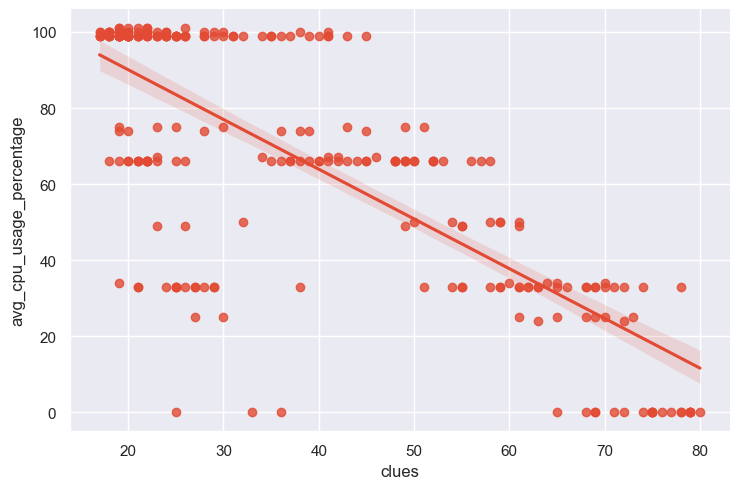

In [33]:
scatterplot_single(csp_df, 'clues', 'avg_cpu_usage_percentage')

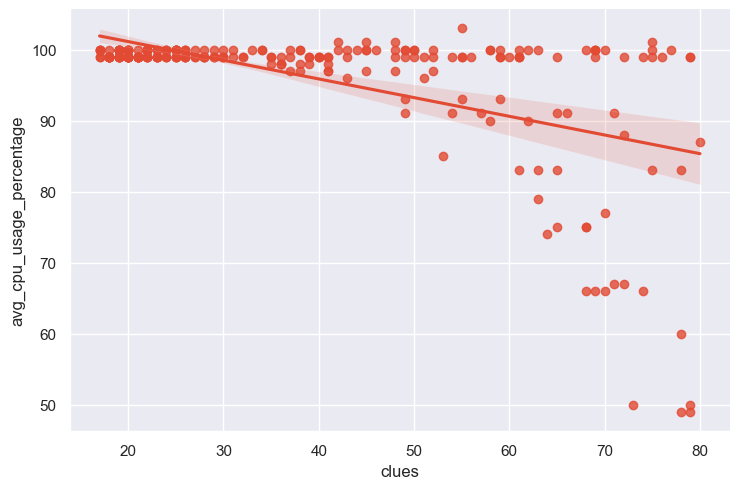

In [34]:
scatterplot_single(lsga_df, 'clues', 'avg_cpu_usage_percentage')

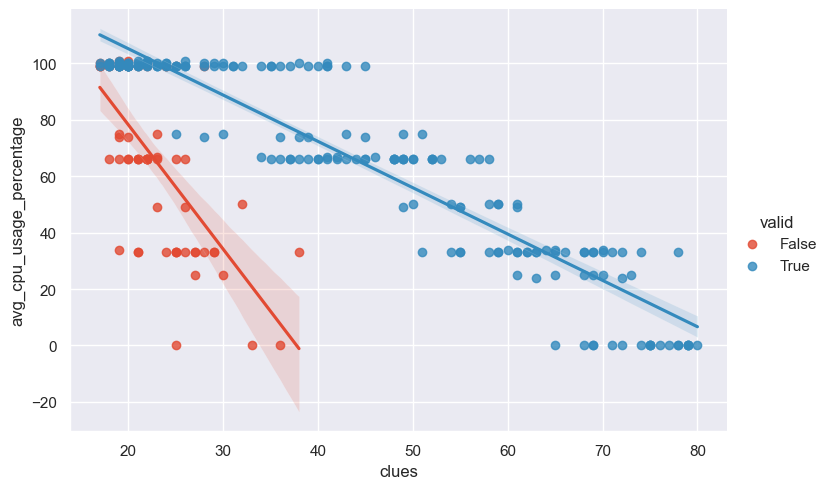

In [35]:
scatterplot_single(csp_df, 'clues', 'avg_cpu_usage_percentage', hue='valid')

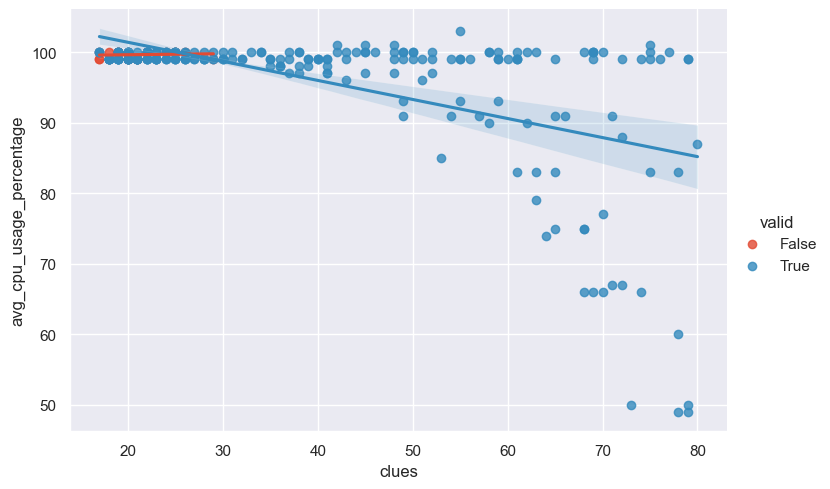

In [36]:
scatterplot_single(lsga_df, 'clues', 'avg_cpu_usage_percentage', hue='valid')

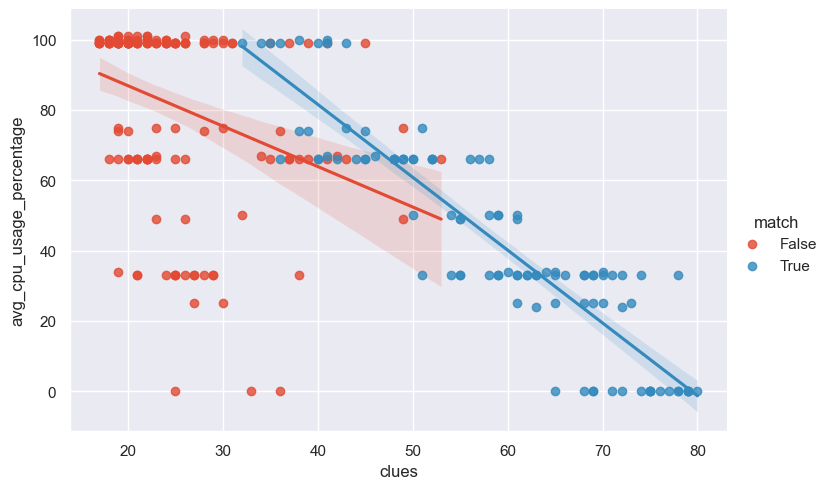

In [37]:
scatterplot_single(csp_df, 'clues', 'avg_cpu_usage_percentage', hue='match')

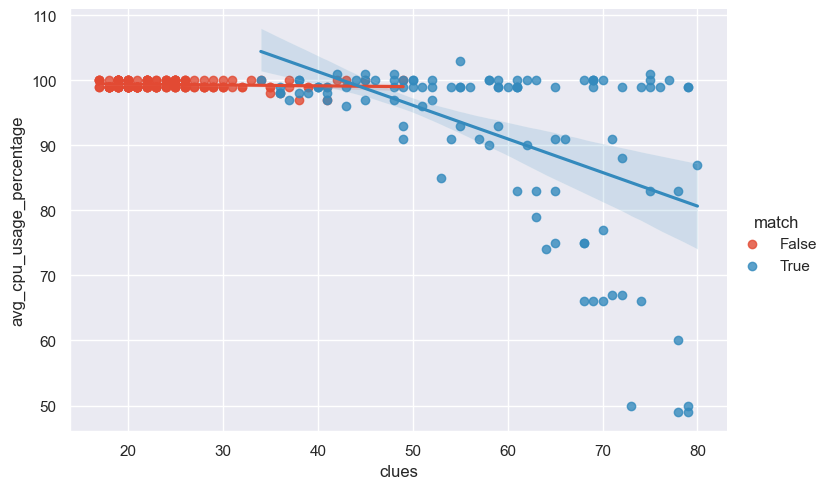

In [38]:
scatterplot_single(lsga_df, 'clues', 'avg_cpu_usage_percentage', hue='match')

### Max CPU Usage

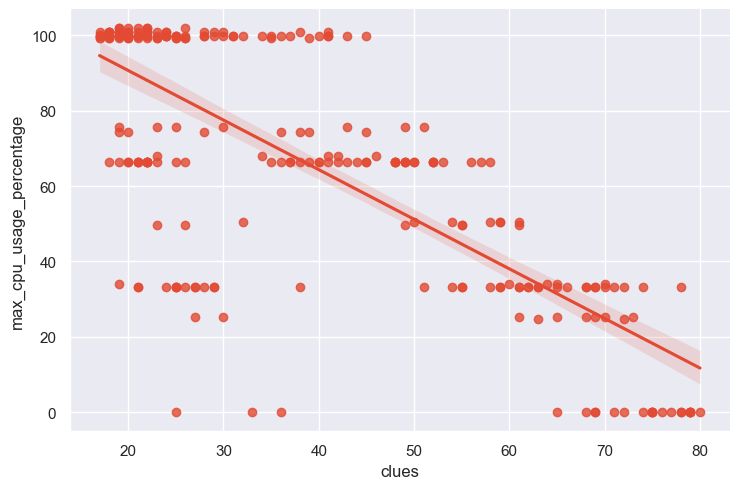

In [28]:
scatterplot_single(csp_df, 'clues', 'max_cpu_usage_percentage')

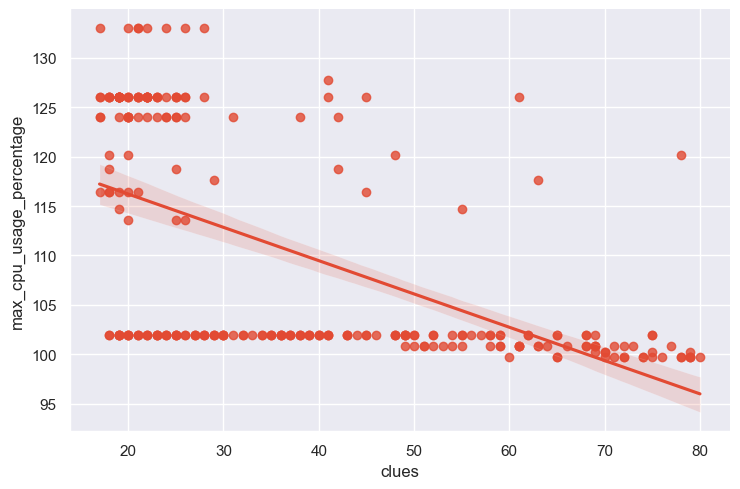

In [29]:
scatterplot_single(lsga_df, 'clues', 'max_cpu_usage_percentage')

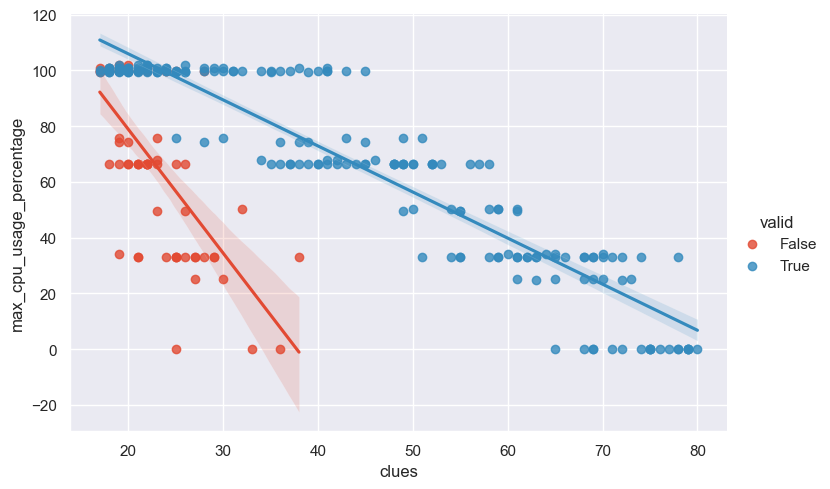

In [30]:
scatterplot_single(csp_df, 'clues', 'max_cpu_usage_percentage', hue='valid')

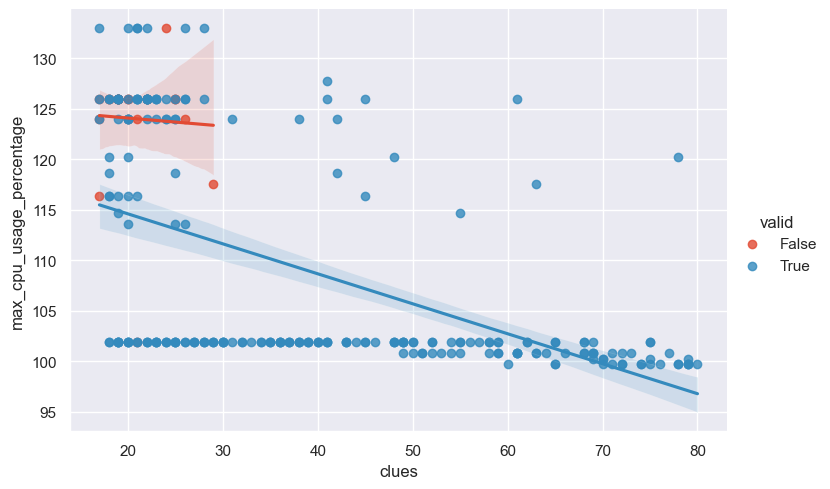

In [31]:
scatterplot_single(lsga_df, 'clues', 'max_cpu_usage_percentage', hue='valid')

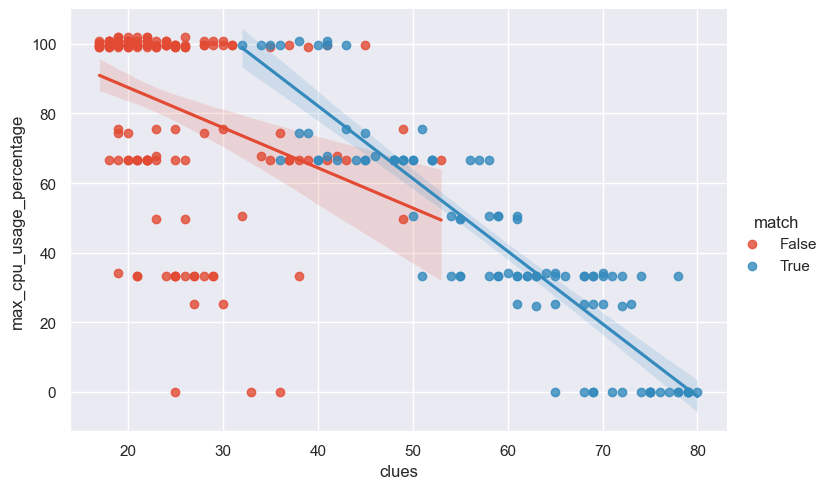

In [32]:
scatterplot_single(csp_df, 'clues', 'max_cpu_usage_percentage', hue='match')

In [ ]:
scatterplot_single(lsga_df, 'clues', 'max_cpu_usage_percentage', hue='match')

### Memory Usage

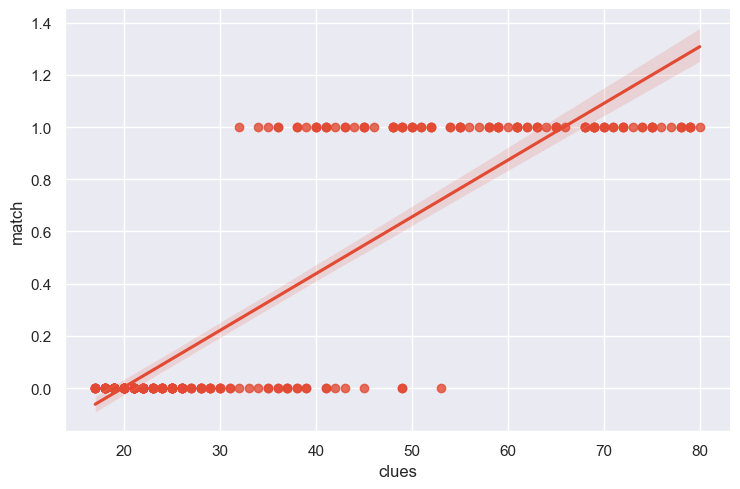

In [69]:
scatterplot_single(csp_df, 'clues', 'match')

In [ ]:
###